In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from scipy import stats
from IPython.display import FileLink
from IPython.display import display
from datetime import timedelta

# Linear Regression Analysis

In [71]:
# User can download any crypto csv file from https://finance.yahoo.com/crypto/ and choose the desire tiem period.
# We choose Bitcoin (BTC) for the purpose of our project, but it would also work for other crypto such as Ethereum(ETH)
df = pd.read_csv('BTC_USD.csv')
df['Date'] = pd.to_datetime(df['Date'])
df["Mean Price"] = df[["Open", "High", "Low", "Close"]].mean(axis = 1)

In [72]:
# Turn date to numeric value
df['Numeric_Date'] = df['Date'].apply(lambda x: x.toordinal())

# Past halving event period, each date back two year prior to the halving event happened, and the next halving event date
halve1_sec = df[(df['Date'] >= '2014-07-09') & (df['Date'] <= '2016-07-09')]
halve2_sec = df[(df['Date'] >= '2016-07-10') & (df['Date'] <= '2020-05-11')]
next_halve_sec = df[(df['Date'] >= '2020-05-12') & (df['Date'] <= '2024-03-30')]
whole_data = df[(df['Date'] >= '2014-09-19') & (df['Date'] <= '2024-03-30')]

In [73]:
def linear_predict(date, data):
    '''
    Given a date, predict the price of bitcoin using linear regression based on the halvin period
    Parameter: date (string), data (halve_1/halve_2/next_halve)
    Return: float
    '''
    numerator_lst = [] 
    denominator_lst = [] 
    mean_date = data[["Numeric_Date"]].mean().iloc[0]
    mean_price = data[["Mean Price"]].mean().iloc[0]
    d_value = datetime.datetime.strptime(date, '%Y-%m-%d')
    ordinal_value = d_value.toordinal()
    # extract the date and price value to form the parameter for the linear regression equation
    for x, y in zip(data["Numeric_Date"].values, data["Mean Price"].values):
        numerator_lst.append((x - mean_date) * (y - mean_price))
        denominator_lst.append((x - mean_date) ** 2)     
    slope = sum(numerator_lst) / sum(denominator_lst)
    intercept = mean_price - slope * mean_date
    predicted_value = slope * ordinal_value + intercept
    return f"The predicted price for the given period: {round(predicted_value, 2)}$"

In [74]:
# predicted price for using the halve_1 period 
linear_predict('2024-04-20', halve1_sec)

'The predicted price for the given period: 1454.0$'

In [75]:
# predicted price for using the halve_2 period 
linear_predict('2024-04-20', halve2_sec)

'The predicted price for the given period: 18086.81$'

In [76]:
# predicted price for using the next_halve period 
linear_predict('2024-04-20', next_halve_sec)

'The predicted price for the given period: 37575.08$'

In [77]:
def h_plot(data):
    '''
    Given the data, plot the regression line and the actual data
    Parameter: data (halve_1/halve_2/next_halve)
    Return: plot
    '''
    numerator_lst = [] 
    denominator_lst = [] 
    mean_date = data[["Numeric_Date"]].mean().iloc[0]
    mean_price = data[["Mean Price"]].mean().iloc[0]
    date_lst = [d for d in data["Numeric_Date"].values]
    price_lst = [p for p in data["Mean Price"].values]
    regression_y = []
    # extract the date and price value to form the parameter for the linear regression equation
    for x, y in zip(data["Numeric_Date"].values, data["Mean Price"].values):
        numerator_lst.append((x - mean_date) * (y - mean_price))
        denominator_lst.append((x - mean_date) ** 2)  
    slope = sum(numerator_lst) / sum(denominator_lst)
    intercept = mean_price - slope * mean_date
    # produce the list of values based on the regression formula
    for date in date_lst:
        regression_y.append(slope* date + intercept)
    # plot the graph of the actual dataset and the calculated value from the regression formula of Bitcoin's price
    plt.figure(figsize=(15, 10))
    plt.plot(data["Date"].values, data["Mean Price"].values,  color='darkblue', label='Actual Data', linewidth=3)
    plt.plot(data["Date"].values, regression_y, color='red', label='Linear Regression Line')
    plt.axvspan(min(halve1_sec["Date"].values), max(halve1_sec["Date"].values), color='green', alpha=0.2, label='Prior Halve1 Time')
    plt.axvspan(min(halve2_sec["Date"].values), max(halve2_sec["Date"].values), color='blue', alpha=0.2, label='Prior Halve2 Time')
    plt.axvspan(min(next_halve_sec["Date"].values), max(next_halve_sec["Date"].values), color='purple', alpha=0.2, label='Prior Next Halve Time')  
    plt.xlabel('Date')
    plt.ylabel('Mean Daily Price ($)')
    plt.title(f'BTC Actual Price vs Linear Regression Line (3/30/24 as last day)')      
    plt.legend()
    plt.grid(True)
    plt.show()  

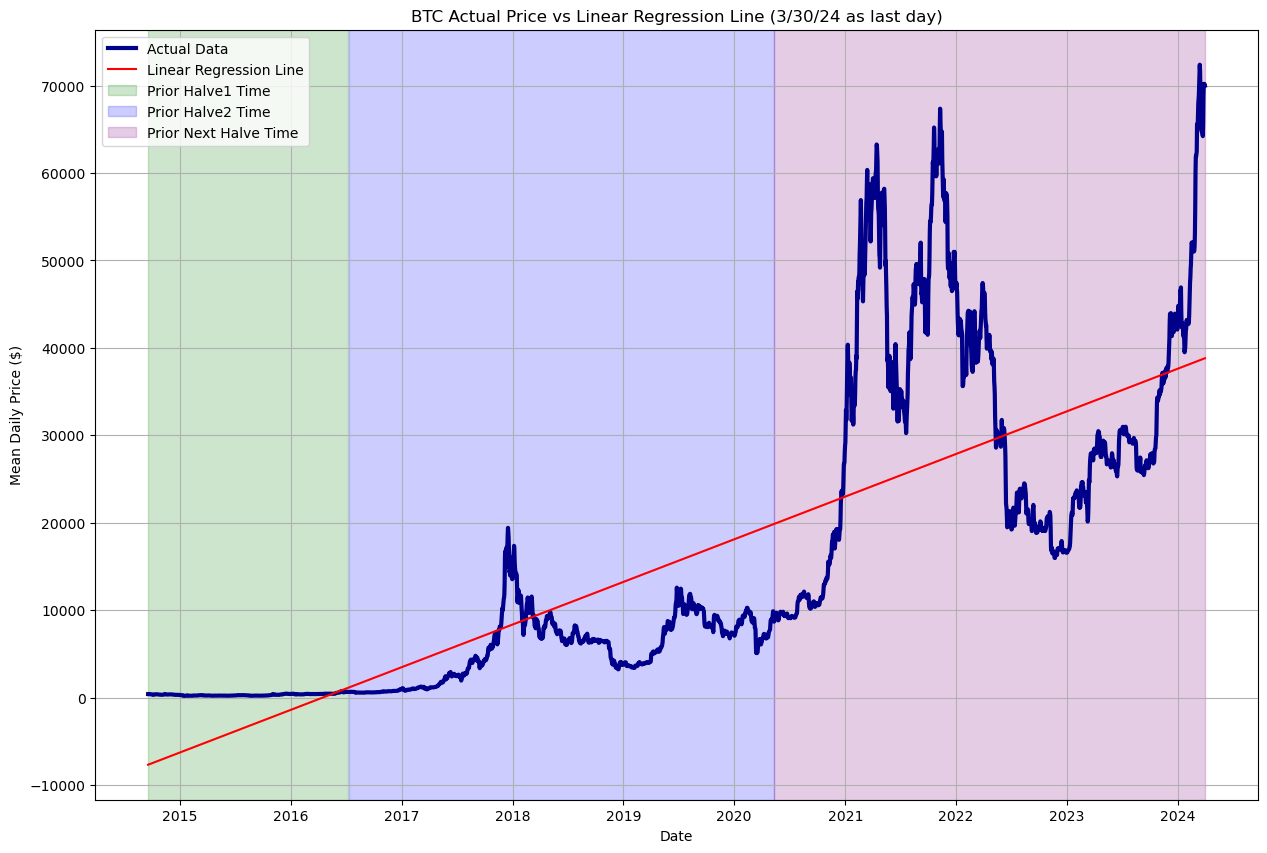

In [78]:
# BTC Actual Price vs Linear Regression Line (3/30/24 as last day) plot
h_plot(whole_data)

# Polynomial Regression Analysis

In [79]:
train_df = df[(df['Date'] >= '2014-09-17') & (df['Date'] <= '2023-09-17')]
test_df = df[(df['Date'] > '2023-09-17') & (df['Date'] <= '2024-03-30')]

In [80]:
# Convert the 'Date' to a more usable numeric feature, 'DayOfYear'
train_df['DayOfYear'] = train_df['Date'].dt.dayofyear
test_df['DayOfYear'] = test_df['Date'].dt.dayofyear

features = ['Open', 'High', 'Low', 'Volume', 'DayOfYear']
X_train = train_df[features]
y_train = train_df['Close']
X_test = test_df[features]
y_test = test_df['Close']

/var/folders/sw/4xrc7st92kl0js_sn1vflh100000gn/T/ipykernel_86327/1029730034.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['DayOfYear'] = train_df['Date'].dt.dayofyear
/var/folders/sw/4xrc7st92kl0js_sn1vflh100000gn/T/ipykernel_86327/1029730034.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['DayOfYear'] = test_df['Date'].dt.dayofyear


In [81]:
degree = 8
poly = PolynomialFeatures(degree=degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [82]:
model = LinearRegression()
model.fit(X_train_poly, y_train)

LinearRegression()

In [83]:
y_pred = model.predict(X_test_poly)
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R-squared: {r2_score(y_test, y_pred)}')

Mean Squared Error: 1070477254.477167
R-squared: -5.7091553059026765


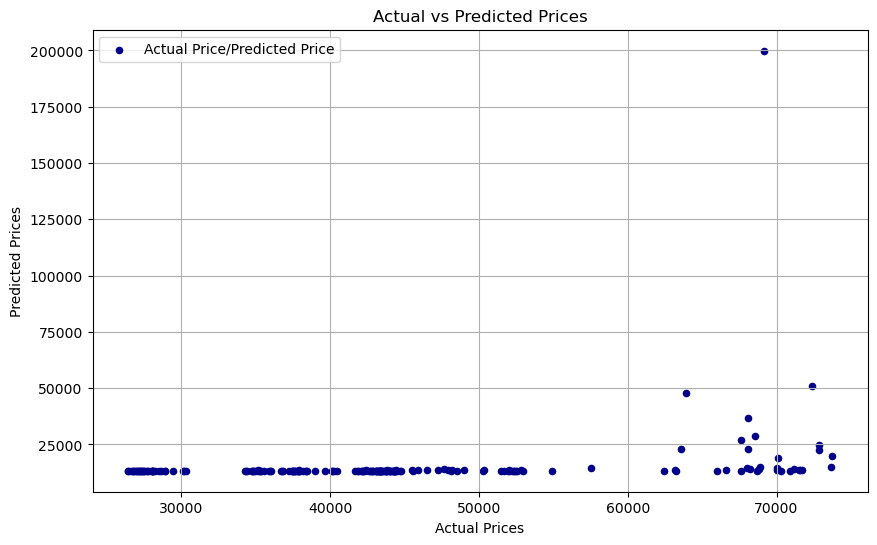

In [84]:
# Actual vs Predicted Prices plot
plt.figure(figsize=(10, 6)) 
plt.scatter(X_test.values[:,1], y_pred, s=20, c='darkblue', label='Actual Price/Predicted Price')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.grid(True)
plt.legend()
plt.show()

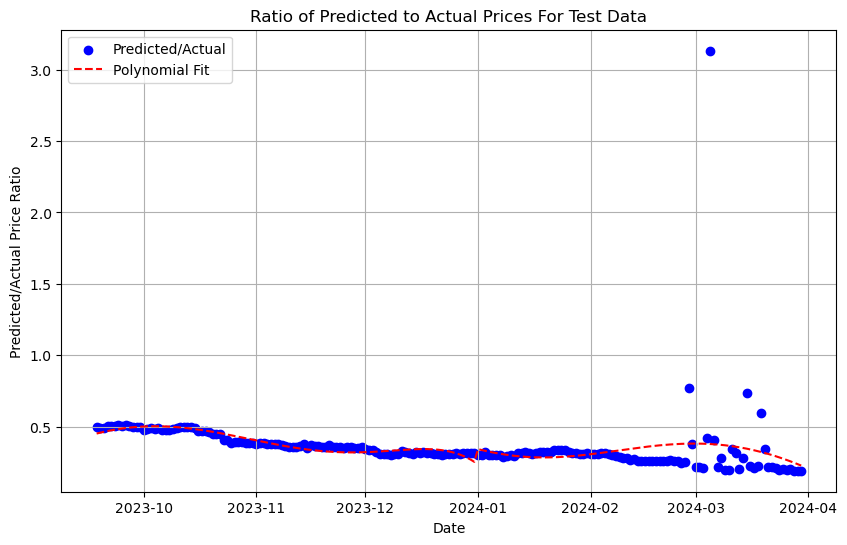

In [85]:
# Ratio of Predicted to Actual Prices For Test Data plot
plt.figure(figsize=(10, 6))
plt.scatter(test_df['Date'], y_pred / y_test, color='blue', label='Predicted/Actual')
plt.title('Ratio of Predicted to Actual Prices For Test Data')
plt.xlabel('Date')
plt.ylabel('Predicted/Actual Price Ratio')

z = np.polyfit(test_df['DayOfYear'], y_pred / y_test, 8)
p = np.poly1d(z)
plt.plot(test_df['Date'], p(test_df['DayOfYear']), "r--", label='Polynomial Fit')

plt.grid(True)
plt.legend()
plt.show()

/var/folders/sw/4xrc7st92kl0js_sn1vflh100000gn/T/ipykernel_86327/1635241147.py:13: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(plot_df['Numeric_Date'], plot_df['Ratio'], 8)


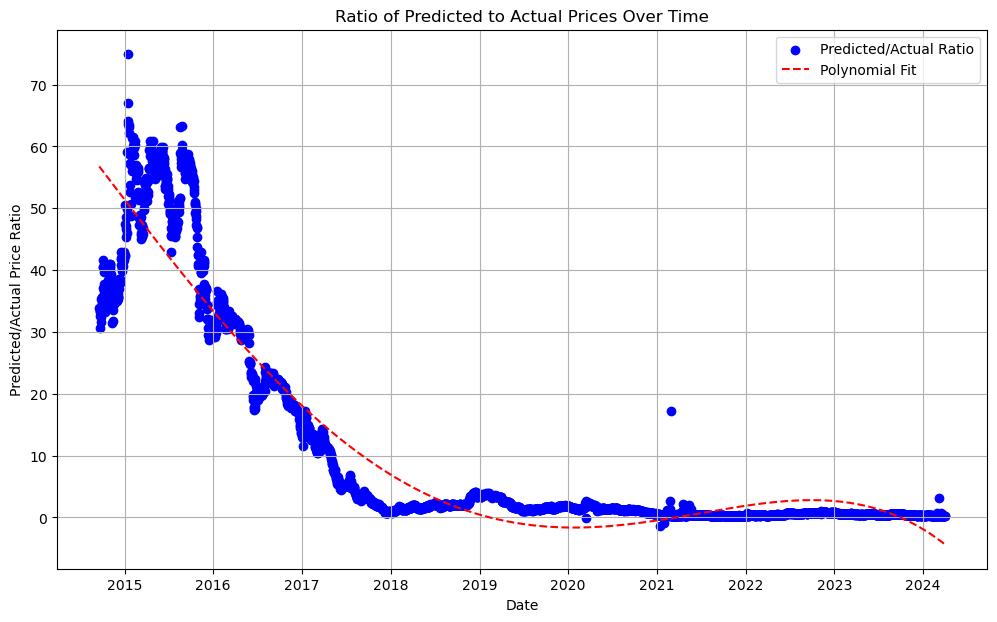

In [86]:
y_train_pred = model.predict(X_train_poly)

combined_predictions = np.concatenate((y_train_pred, y_pred), axis=0)
combined_actuals = pd.concat([y_train, y_test])


plot_df = pd.DataFrame({'Date': pd.concat([train_df['Date'], test_df['Date']]),  # Combine dates
                        'Predicted': combined_predictions,
                        'Actual': combined_actuals}).sort_values('Date')

plot_df['Ratio'] = plot_df['Predicted'] / plot_df['Actual']
plot_df['Numeric_Date'] = plot_df['Date'].apply(lambda x: x.toordinal())
z = np.polyfit(plot_df['Numeric_Date'], plot_df['Ratio'], 8)
p = np.poly1d(z)

# Ratio of Predicted to Actual Prices Over Time
plt.figure(figsize=(12, 7))
plt.scatter(plot_df['Date'], plot_df['Ratio'], color='blue', label='Predicted/Actual Ratio')
date_range_numeric = plot_df['Numeric_Date']
plt.plot(plot_df['Date'], p(date_range_numeric), "r--", label='Polynomial Fit')
plt.title('Ratio of Predicted to Actual Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Predicted/Actual Price Ratio')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
df.dropna(inplace=True)

# Feature Engineering: Creating new features or transforming existing ones
 # Log-transform of Volume to reduce skewness
df['LogVolume'] = np.log(df['Volume'] + 1)  
# Adding the day of the week might capture weekly seasonality
df['DayOfWeek'] = df['Date'].dt.dayofweek   

# Normalizing some features could also help
df['NormalizedHigh'] = (df['High'] - df['High'].min()) / (df['High'].max() - df['High'].min())

# Use more historical data points, such as previous day's price
df['PrevClose'] = df['Close'].shift(1)
# Because shifting creates NaN values
df.dropna(inplace=True)  

In [97]:
# Instead of using a high degree, start with a lower one
poly_degree = 8  
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)

In [98]:
train_1 = df[df['Date'] <= '2023-09-17']
test_1 = df[df['Date'] > '2023-09-17']

# Feature selection
features = ['Open', 'High', 'Low', 'LogVolume', 'DayOfWeek', 'NormalizedHigh', 'PrevClose']
X_train = poly_features.fit_transform(train_1[features])
y_train = train_1['Close']
X_test = poly_features.transform(test_1[features])
y_test = test_1['Close']

In [99]:
# Using Ridge regression to add regularization
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

Ridge()

In [100]:
y_pred = ridge_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 664809598593.8499
R-squared: -4165.656346191514


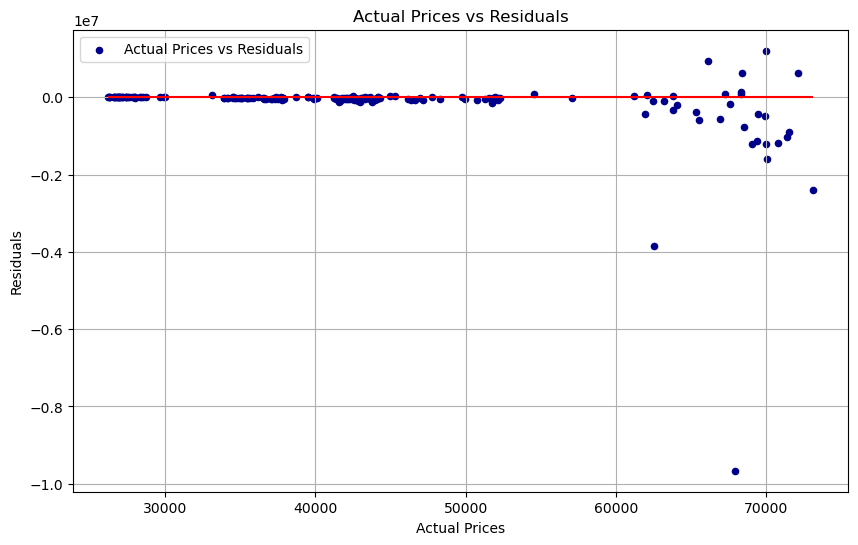

In [101]:
# Plot the actual price vs residual graph
residuals = y_test - y_pred

plt.figure(figsize=(10, 6)) 
plt.scatter(y_test, residuals, s=20, c='darkblue', label='Actual Prices vs Residuals')
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max(), colors='red')
plt.xlabel('Actual Prices')
plt.ylabel('Residuals')
plt.title('Actual Prices vs Residuals')
plt.grid(True)
plt.legend()
plt.show()

In [102]:
# Using cross-validation to evaluate the model
scores = cross_val_score(ridge_model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-scores)

print(f'Scores: {rmse_scores}')
print(f'Mean: {rmse_scores.mean()}')

Scores: [5.90122609e+03 5.21935159e+03 4.04387655e+03 1.43852162e+08
 1.81932218e+04]
Mean: 28777103.846825384


# Predition

In [103]:
start_date = datetime.datetime(2024, 4, 20)
end_date = datetime.datetime(2024, 12, 31)
delta = timedelta(days=1)

future_dates = []
while start_date <= end_date:
    future_dates.append(start_date)
    start_date += delta

future_df = pd.DataFrame(future_dates, columns=['Date'])
future_df['DayOfYear'] = future_df['Date'].dt.dayofyear

# Assuming the synthetic values for 'Open', 'High', 'Low', 'Volume' are the average of the last 30 days
last_values = df[-30:]
synthetic_open = last_values['Open'].mean()
synthetic_high = last_values['High'].mean()
synthetic_low = last_values['Low'].mean()
synthetic_volume = last_values['Volume'].mean()

future_df['Open'] = synthetic_open
future_df['High'] = synthetic_high
future_df['Low'] = synthetic_low
future_df['Volume'] = synthetic_volume

features = ['Open', 'High', 'Low', 'Volume', 'DayOfYear']

X_future = future_df[features]
X_future_poly = poly.transform(X_future)

# Predicting 'Close' prices
y_future_pred = model.predict(X_future_poly)

future_df['Predicted Close'] = y_future_pred
future_df.head()

,Date,DayOfYear,Open,High,Low,Volume,Predicted Close
0,2024-04-20,111,67296.795703,69199.928256,65402.565625,4.756103e+10,14672.431942
1,2024-04-21,112,67296.795703,69199.928256,65402.565625,4.756103e+10,14673.781306
2,2024-04-22,113,67296.795703,69199.928256,65402.565625,4.756103e+10,14675.130671
3,2024-04-23,114,67296.795703,69199.928256,65402.565625,4.756103e+10,14676.480036
4,2024-04-24,115,67296.795703,69199.928256,65402.565625,4.756103e+10,14677.829400


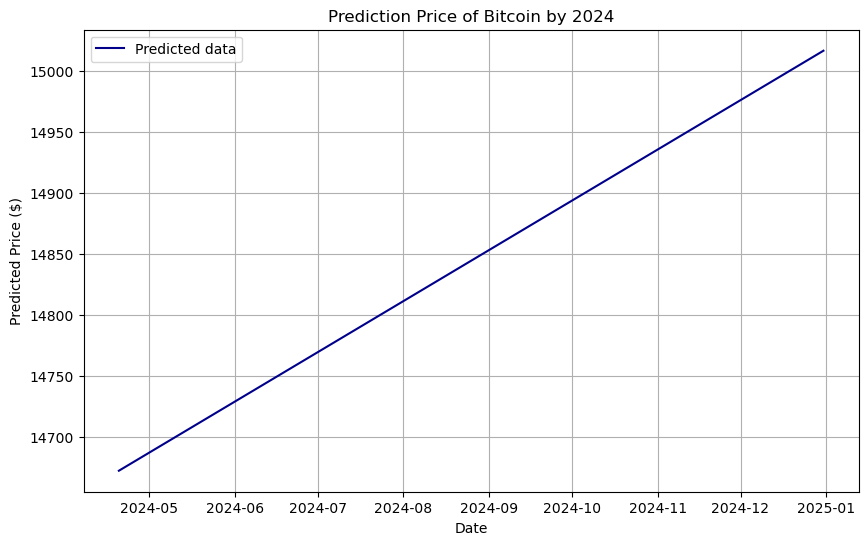

In [104]:
# Plot for the predicted price of Bitcoin to the end of 2024
plt.figure(figsize=(10, 6))
plt.plot(future_df["Date"].values, future_df["Predicted Close"].values, color='darkblue', label='Predicted data')
plt.xlabel('Date')
plt.ylabel('Predicted Price ($)')
plt.title("Prediction Price of Bitcoin by 2024")      
plt.legend()
plt.grid(True)
plt.show()    

In [105]:
# Create a prediction price file of the rest of 2024 timeframe
prediction_file_path = 'BTC_USD_Predictions_2024.csv'
future_df.to_csv(prediction_file_path, index=False)

display(FileLink(prediction_file_path))

/Users/hydec5even/Desktop/Jupyter/BTC_USD_Predictions_2024.csv